### V5: Fine Tune BERT
- Train Data
- Stride 64
- Down Sampling 'O' Label 0.30
- External Dataset

Trained on Kaggle GPU P100 x1

Leaderboard 
- Public Score: 0.90284
- Private Score: 0.90314

In [3]:
!pip install seqeval
!pip install accelerate

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from datasets import Dataset
from functools import partial
from seqeval.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from tqdm import tqdm

2024-04-18 02:29:50.871379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 02:29:50.871479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 02:29:51.014982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class Setting:
    seed = 42
    base_dir = "/kaggle/input"

    # data
    data_train = f"{base_dir}/pii-detection-removal-from-educational-data/train.json"
    data_nbroad = f"{base_dir}/pii-dd-mistral-generated/mixtral-8x7b-v1.json"
    data_valentinwerner = f"{base_dir}/pii-label-specific-data/all_labels.json"
    data_alejopaulier = f"{base_dir}/fix-punctuation-tokenization-external-dataset/pii_dataset_fixed.json"
    data_pjmathematician = f"{base_dir}/fix-punctuation-tokenization-external-dataset/moredata_dataset_fixed.json"
    data_minhsienweng = f"{base_dir}/create-ai-generated-essays-using-llm/pii_dataset_Gemma.json"
    data_mandrilator = f"{base_dir}/pii-mistral-2k-fit-competition-v2/all_labels.json"

    down_sample_ratio = 0.30

    # model
    model_checkpoint = "google-bert/bert-base-uncased"
    model_train = '/kaggle/working/model/v5/train'
    model_final = '/kaggle/working/model/v5/final'
    max_length = 512
    stride = 64

    # hyperparameter
    epochs = 10
    learning_rate = 3e-5
    warmup_ratio = 0.1
    lr_scheduler_type='cosine'
    weight_decay = 0.01
    grad_steps = 2
    batch_size = 16

    # PII (NER) tags
    labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
              "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
              "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
              "I-STREET_ADDRESS","I-URL_PERSONAL","O"]
    id2label = dict(enumerate(labels)) # integer label to BIO format label mapping
    label2id = {v:k for k,v in id2label.items()} # BIO format label to integer label mapping
    num_labels = len(labels) # number of PII (NER) tags

In [6]:
np.random.seed(Setting.seed)
torch.manual_seed(Setting.seed)

In [7]:
# read and combine all dataset
df_train = pd.read_json(Setting.data_train)
df_nbroad = pd.read_json(Setting.data_nbroad)
df_valentinwerner = pd.read_json(Setting.data_valentinwerner)
df_alejopaulier = pd.read_json(Setting.data_alejopaulier)
df_pjmathematician = pd.read_json(Setting.data_pjmathematician)
df_minhsienweng = pd.read_json(Setting.data_minhsienweng)
df_mandrilator = pd.read_json(Setting.data_mandrilator)

features = ['tokens', 'labels']
df = pd.concat([df_train[features],
                   df_nbroad[features],
                   df_valentinwerner[features],
                   df_alejopaulier[features],
                   df_pjmathematician[features],
                   df_minhsienweng[features],
                   df_mandrilator[features]],
                   ignore_index=True)

df = df[['tokens', 'labels']]
df.rename(columns={"labels": "pii_labels"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      27442 non-null  object
 1   pii_labels  27442 non-null  object
dtypes: object(2)
memory usage: 428.9+ KB


In [8]:
def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column,
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    # show percentage on bar for first 3 bars
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)
    ax.get_legend().remove()
    plt.show()

def down_sample(df, down_sample_ratio, seed):
    df['non_pii_entity_only'] = df['pii_labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))

    df_non_pii_entity_only = df[df['non_pii_entity_only']].sample(frac=down_sample_ratio, random_state=seed)
    df_with_pii_entity = df[~df['non_pii_entity_only']]
    df = pd.concat([df_with_pii_entity, df_non_pii_entity_only])

    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())

    df.drop(columns=['non_pii_entity_only'], inplace=True)
    return df

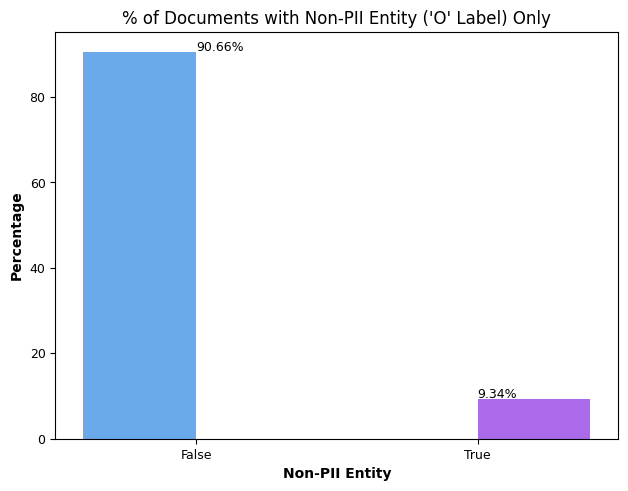

non_pii_entity_only
False    20430
True      2104
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22534 entries, 0 to 23091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      22534 non-null  object
 1   pii_labels  22534 non-null  object
dtypes: object(2)
memory usage: 528.1+ KB


In [9]:
df = down_sample(df, Setting.down_sample_ratio, Setting.seed)
df.info()

In [10]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['tokens', 'pii_labels', '__index_level_0__'],
    num_rows: 22534
})

In [11]:
ds = ds.train_test_split(test_size=0.25, seed=Setting.seed)
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pii_labels', '__index_level_0__'],
        num_rows: 16900
    })
    test: Dataset({
        features: ['tokens', 'pii_labels', '__index_level_0__'],
        num_rows: 5634
    })
})

In [12]:
def tokenize_and_align_labels(example, tokenizer, label2id, max_length, stride):
    tokenized_inputs = tokenizer(example["tokens"],
                                 truncation=True,
                                 max_length=max_length,
                                 stride=stride,
                                 padding="max_length",
                                 is_split_into_words=True,
                                 return_overflowing_tokens=True)
    tokenized_overflow_mappings = tokenized_inputs.overflow_to_sample_mapping
    labels = []
    #print(len(example["tokens"]), len(tokenized_overflow_mappings))
    for idx, overflow_mapping_id in enumerate(tokenized_overflow_mappings):
        label_ids = []
        previous_word_idx = None
        word_ids = tokenized_inputs.word_ids(batch_index=idx) # map tokens to their respective words
        label = example["pii_labels"]
        # using the overflow_mapping_id
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [13]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint)

tokenized_ds = ds.map(tokenize_and_align_labels,
                      fn_kwargs={"tokenizer": tokenizer,
                                 "label2id": Setting.label2id,
                                 "max_length": Setting.max_length,
                                 "stride": Setting.stride
                                }, num_proc=4)
tokenized_ds = tokenized_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])
tokenized_ds

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/16900 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/5634 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 16900
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5634
    })
})

In [14]:
def rearrange_tokenized_input(dataset):
    tokenized = {
        "input_ids": [],
        "labels": [],
        "attention_mask": [],
    }
    for i in tqdm(range(len(dataset))):
        doc = dataset[i]
        for j in range(len(doc["input_ids"])):
            tokenized["input_ids"].append(doc["input_ids"][j])
            tokenized["labels"].append(doc["labels"][j])
            tokenized["attention_mask"].append(doc["attention_mask"][j])
    return tokenized

In [15]:
# rearrange tokenized data to model input format
tokenized_ds["train"] = Dataset.from_dict(rearrange_tokenized_input(tokenized_ds["train"]))
tokenized_ds["test"] = Dataset.from_dict(rearrange_tokenized_input(tokenized_ds["test"]))
tokenized_ds

100%|██████████| 5634/5634 [00:11<00:00, 489.54it/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 25870
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 8597
    })
})

In [16]:
def compute_metrics(p, id2label):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    report = classification_report(y_true=true_labels, y_pred=true_predictions, output_dict=True)
    micro_avg = report.pop("micro avg")
    accuracy = accuracy_score(y_true=true_labels, y_pred=true_predictions)

    return {
        "precision": micro_avg["precision"],
        "recall": micro_avg["recall"],
        "f1": micro_avg["f1-score"],
        "accuracy": accuracy
    }

In [17]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

model = AutoModelForTokenClassification.from_pretrained(
    Setting.model_checkpoint,
    num_labels=Setting.num_labels,
    id2label=Setting.id2label,
    label2id=Setting.label2id
)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [18]:
trainer.train()
print(trainer.state.best_model_checkpoint)
trainer.save_model(Setting.model_final)
tokenizer.save_pretrained(Setting.model_final)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.328800,0.015266,0.849759,0.841859,0.845791,0.995639
2,0.007500,0.008057,0.929136,0.878081,0.902887,0.997393
4,0.004500,0.008389,0.961538,0.868233,0.912507,0.997683
6,0.002400,0.011368,0.928273,0.884681,0.905953,0.997510
8,0.001300,0.014730,0.932832,0.886436,0.909042,0.997570
9,0.001100,0.014680,0.928685,0.888819,0.908315,0.997549


/kaggle/working/model/v5/train/checkpoint-4042


('/kaggle/working/model/v5/final/tokenizer_config.json',
 '/kaggle/working/model/v5/final/special_tokens_map.json',
 '/kaggle/working/model/v5/final/vocab.txt',
 '/kaggle/working/model/v5/final/added_tokens.json',
 '/kaggle/working/model/v5/final/tokenizer.json')